# Clasificación con máquina de vectores de soporte y redes de neuronas
## RafaCastle

### Notas importantes

Este código no es óptimo, su objetivo no es optimizar los recusos de la máquina sino ilustrar el proceso para crear el modelo. Muchas de las líneas podrían optimizarse o incluso quitarse y el código seguiría arrojando los mismos resultados, sin embargo, se muestran partes importantes en el desarrollo de una manera ilustrativa. Su objetivo es principalmente informativo.

El código esta hecho para correse de arriba hacia abajo, es decir, si no se corre en orden, o si se intenta volver a correr una celda habiendo corrido algunas posteriores, podría arrojar resultados diferentes. Si se desea volver a correr una celda ya habiendo corrido las posteriores recomiendo mejor reiniciar el kernel y correr las celdas desde el inicio para evitar resultados extraños.

Importando librerías

In [1]:
# librerías básicas
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# gráficos
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from matplotlib import colors
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib as mpl

# sklearn y métricas
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix
from yellowbrick.target import ClassBalance
from yellowbrick.classifier import ConfusionMatrix, ClassificationReport

# redes neuronales
from keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

## Análisis descriptivo de los datos

Importando el archivo a un dataframe.

Fuente: https://www.kaggle.com/iabhishekofficial/mobile-price-classification#train.csv

In [2]:
df = pd.read_csv('train.csv')
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,...,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842,0,2.2,0,1,0,7,0.6,188,2,...,20,756,2549,9,7,19,0,0,1,1
1,1021,1,0.5,1,0,1,53,0.7,136,3,...,905,1988,2631,17,3,7,1,1,0,2
2,563,1,0.5,1,2,1,41,0.9,145,5,...,1263,1716,2603,11,2,9,1,1,0,2
3,615,1,2.5,0,0,0,10,0.8,131,6,...,1216,1786,2769,16,8,11,1,0,0,2
4,1821,1,1.2,0,13,1,44,0.6,141,2,...,1208,1212,1411,8,2,15,1,1,0,1


columnas y renglones

In [3]:
df.shape

(2000, 21)

Información general

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  touch_sc

No hay valores nulos!

Veamos los valores categóricos y numéricos

In [5]:
# Valores categóricos
df_categorico = df[['price_range', 'n_cores', 'blue', 'dual_sim', 'four_g', 'three_g', 'touch_screen', 'wifi']].astype(str)

# Valores numéricos
df_numerico = df.drop(df_categorico.columns, axis=1)

# Descripción de los valores numéricos
df_numerico.describe().T.round(1)

,count,mean,std,min,25%,50%,75%,max
battery_power,2000.0,1238.5,439.4,501.0,851.8,1226.0,1615.2,1998.0
clock_speed,2000.0,1.5,0.8,0.5,0.7,1.5,2.2,3.0
fc,2000.0,4.3,4.3,0.0,1.0,3.0,7.0,19.0
int_memory,2000.0,32.0,18.1,2.0,16.0,32.0,48.0,64.0
m_dep,2000.0,0.5,0.3,0.1,0.2,0.5,0.8,1.0
mobile_wt,2000.0,140.2,35.4,80.0,109.0,141.0,170.0,200.0
pc,2000.0,9.9,6.1,0.0,5.0,10.0,15.0,20.0
px_height,2000.0,645.1,443.8,0.0,282.8,564.0,947.2,1960.0
px_width,2000.0,1251.5,432.2,500.0,874.8,1247.0,1633.0,1998.0
ram,2000.0,2124.2,1084.7,256.0,1207.5,2146.5,3064.5,3998.0


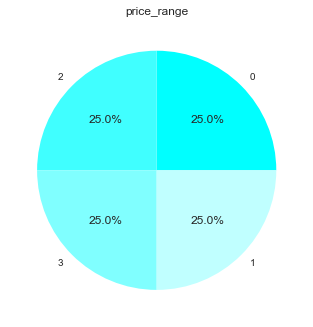

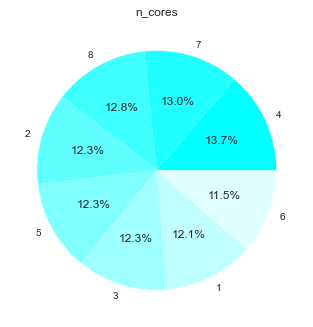

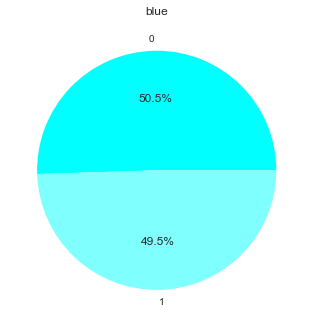

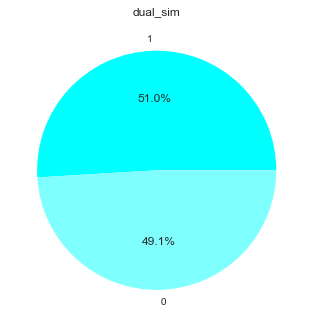

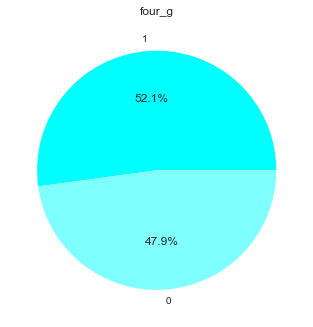

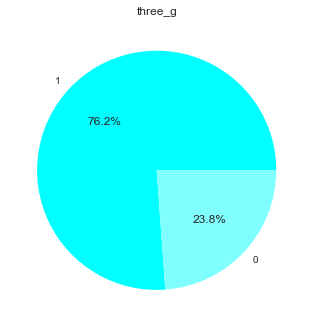

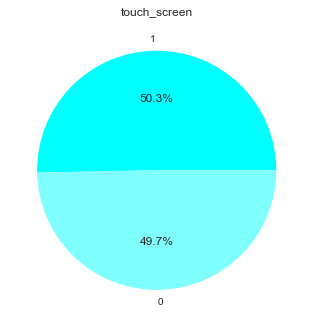

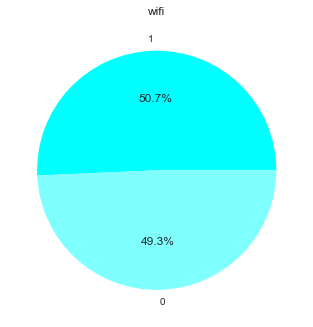

In [39]:
# Descripción de los valores categóricos
for i, valor in enumerate(df_categorico.columns):
    
    value_counts = df_categorico[valor].value_counts()
    etiquetas = value_counts.index.tolist()
    valores = value_counts.values.tolist()

    # Definiendo paleta de colores
    cmap = colors.LinearSegmentedColormap.from_list("BuGn", ['aqua','white'])
    norm = colors.Normalize(vmin=0, vmax=len(etiquetas))
    lista_colores = [colors.rgb2hex(cmap(norm(i))) for i in range(len(etiquetas))]

    # Gráfico de tarta
    plt.pie(
        value_counts,
        labels=etiquetas,
        colors = lista_colores,
        autopct='%1.1f%%')
    plt.title(valor)
    plt.show()

En general los valores categóricos están bien balanceados, excepto por 3g

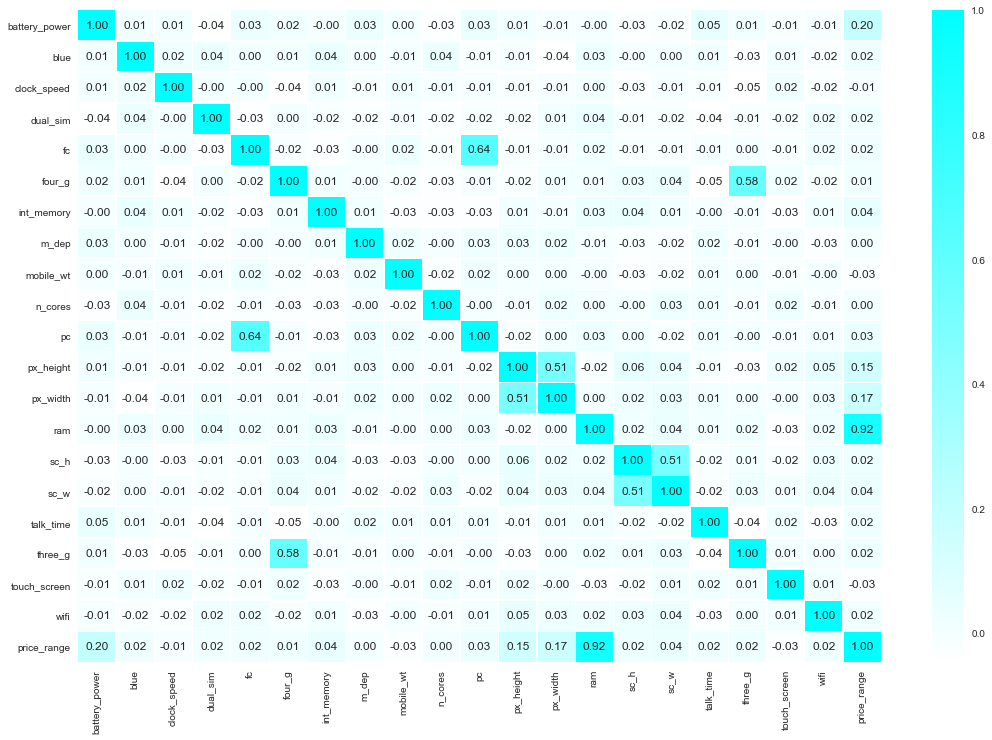

In [40]:
# Definiendo la paleta de colores
paleta_colores = LinearSegmentedColormap.from_list("BuGn", ['white','aqua'])

# Correlación
objetivo = 'price_range'
df_ordenado = pd.concat([df.drop(objetivo,axis=1), df[objetivo]],axis=1)
corr = df_ordenado.corr()

# Gráfico de correlación
plt.figure(figsize=(18,12))
sns.heatmap(corr, annot=True, cmap=paleta_colores, fmt='.2f', linewidths=0.2)
plt.show()

Graficando las correlaciones con la variable objetivo en orden

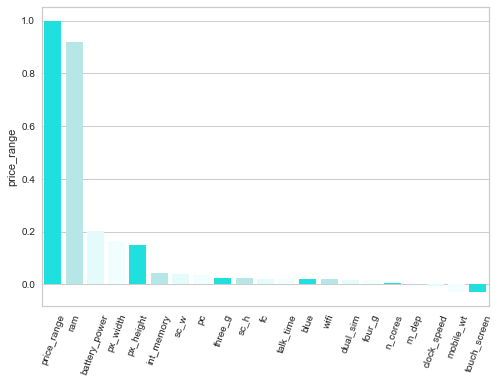

In [47]:
# Seleccionando y ordenando
correlacion_objetivo = corr[["price_range"]].sort_values(by="price_range",ascending=False)

# Graficando
sns.barplot(data=correlacion_objetivo, x = correlacion_objetivo.index, y = "price_range", orient="v",
            palette = ['aqua','paleturquoise','lightcyan','azure'])
plt.xticks(rotation = 70)
plt.show()

Vemos que 4 variables se relacionan fuertemente con la variable objetivo:

 1. ram
 2. battery_power
 3. px_width
 4. px_height
 
Veamos como se distribuyen las variables numéricas de acuerdo con los rangos de precios:

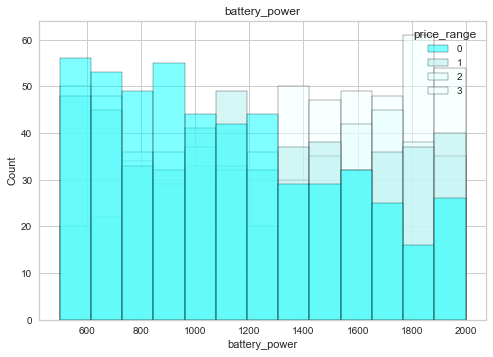

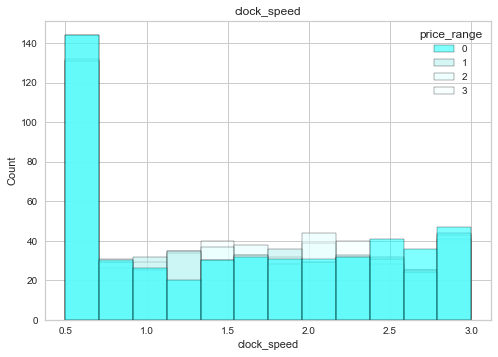

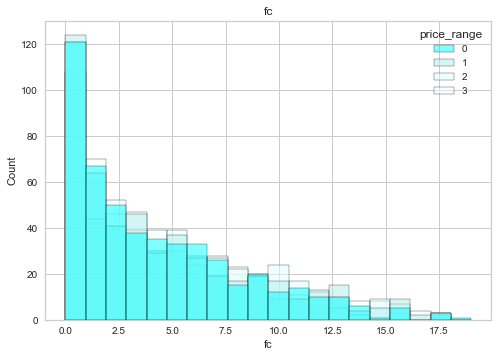

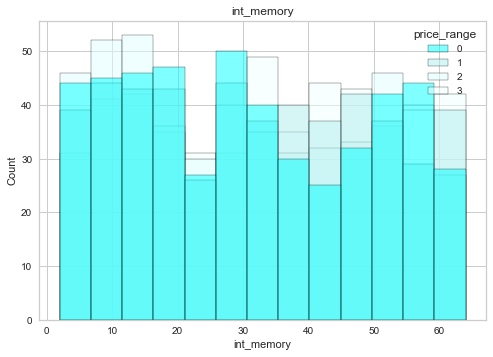

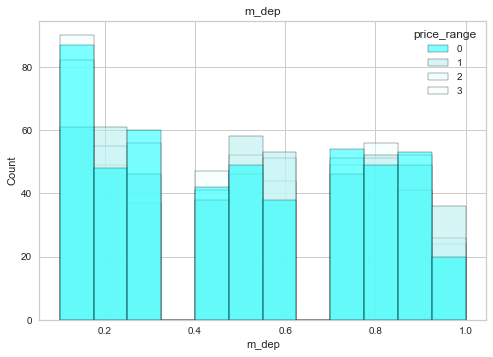

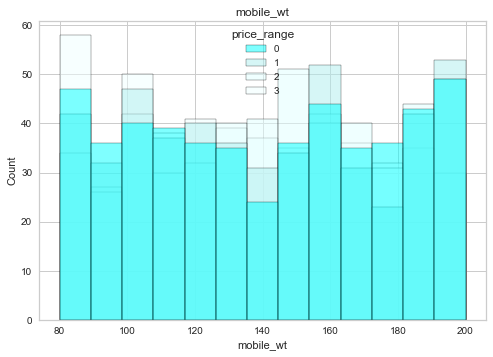

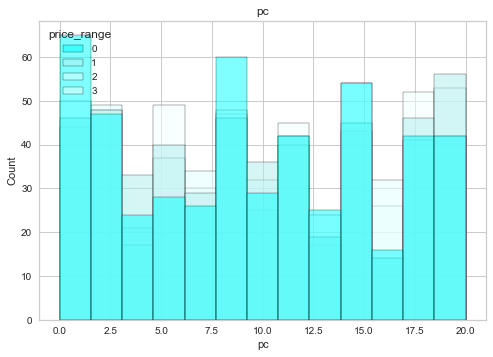

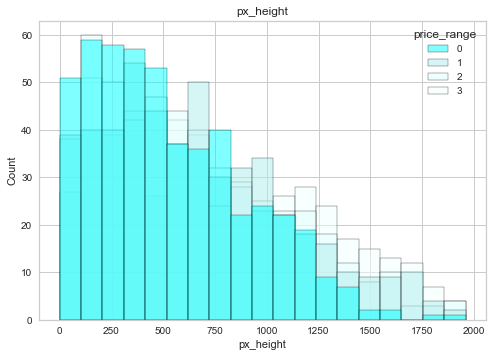

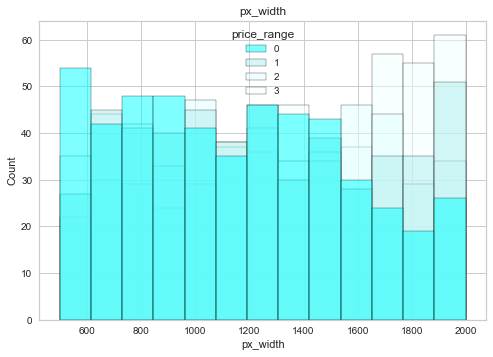

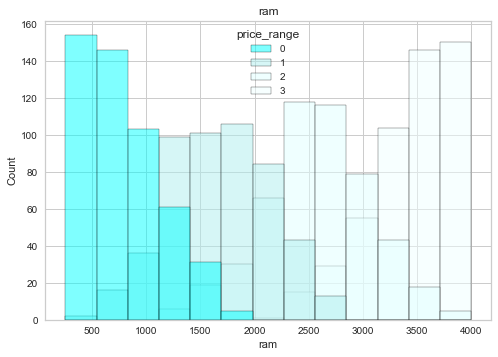

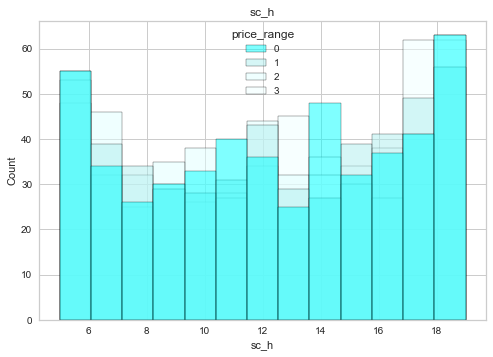

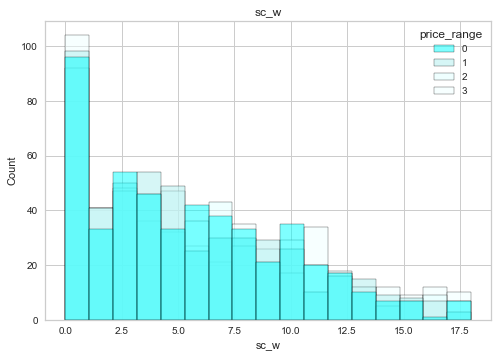

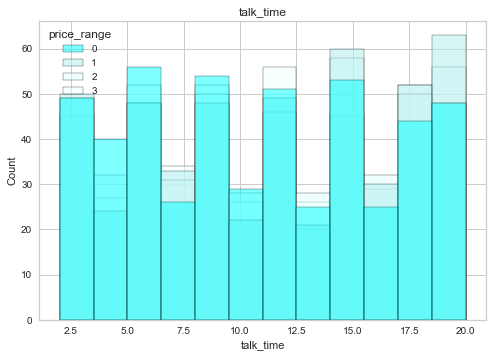

In [48]:
for i in df_numerico.columns:
    sns.histplot(data=df, x=i, hue='price_range',palette = ['aqua','paleturquoise','lightcyan','azure'])
    plt.title(f'{i}')
    plt.show()

Veamos como se relacionan las variables con mayor correlación con respecto a la variable objetivo:

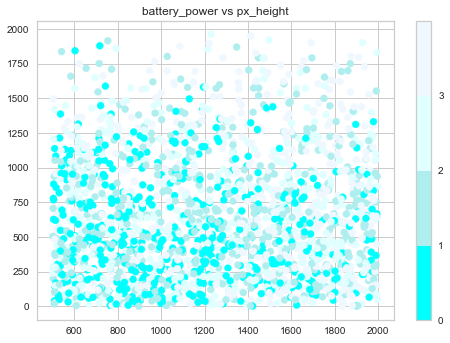

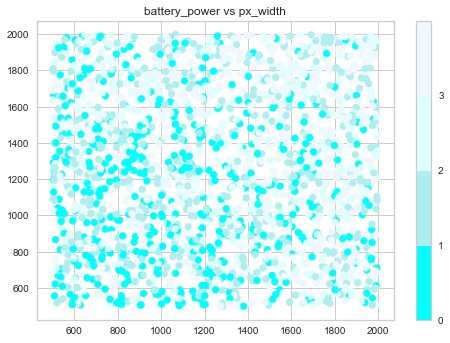

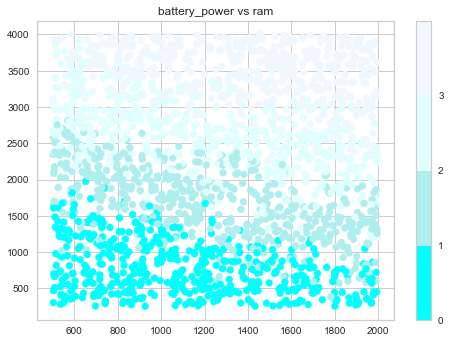

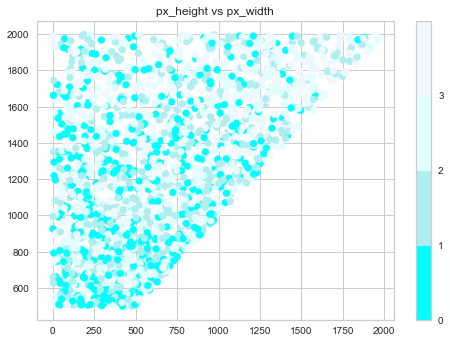

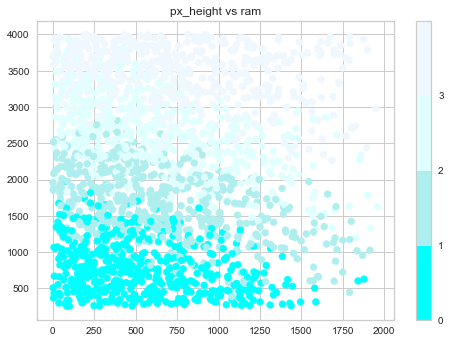

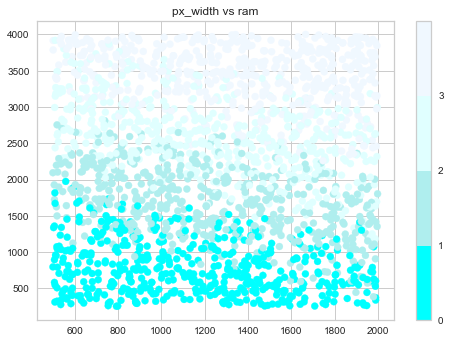

In [51]:
for f1,valor1 in enumerate(['battery_power', 'px_height', 'px_width', 'ram']):
    for f2,valor2 in enumerate(['battery_power', 'px_height', 'px_width', 'ram']):
        if f1<f2:
            x = df[valor1]
            y = df[valor2]
            etiqueta = df['price_range']
            colores = ['aqua','paleturquoise','lightcyan','aliceblue']

            plt.scatter(x, y, c=etiqueta, cmap=ListedColormap(colores))

            cb = plt.colorbar()
            loc = np.arange(0,max(etiqueta),max(etiqueta)/float(len(colores)))
            cb.set_ticks(loc)
            cb.set_ticklabels([0,1,2,3])
            plt.title(f'{valor1} vs {valor2}')
            plt.show()

Es clara una segmentación al graficar la memoria ram contra px_height, px_weight y battery_power.

# SVM

Ahora apliquemos la clasificación con el modelo SVM, primero dividamos en conjuntos de prueba y entrenamiento:

In [11]:
y = df["price_range"].values
X=df.drop(["price_range"],axis=1)

# escalando
X = (X-np.min(X))/(np.max(X)-np.min(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

Hagamos una primera predicción sin hacerle nada especial al modelo y veamos su accuracy:

In [12]:
svm=SVC(random_state=1)
svm.fit(X_train,y_train)
print("accuracy entrenamiento:",svm.score(X_train,y_train))
print("accuracy prueba:",svm.score(X_test,y_test))

accuracy entrenamiento: 0.97375
accuracy prueba: 0.865


Obtengamos la matriz de confusión:

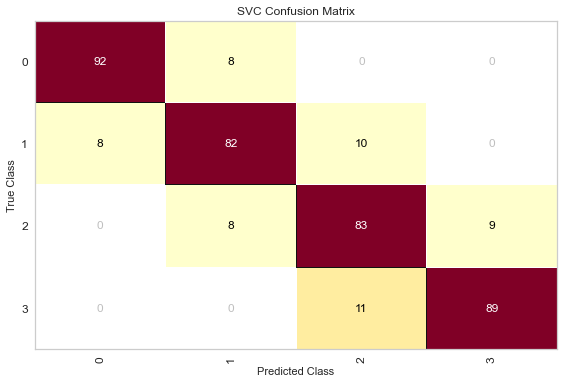

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [13]:
cm = ConfusionMatrix(
    svm, classes=[0,1,2,3]
)

cm.fit(X_train, y_train)
cm.score(X_test, y_test)

cm.poof()

Ahora analicemos las métricas:

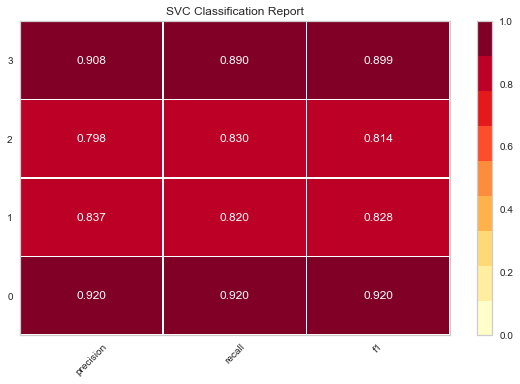

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [14]:
# Rangos de precios
clases = [0,1,2,3]

# Veamos el reporte de la clasificación
visualizador = ClassificationReport(svm, classes=clases)
visualizador.fit(X_train, y_train)        
visualizador.score(X_test, y_test)        
visualizador.show()                      

## Mejorando SVM

Para mejorar las métricas del modelo, intentemos seleccionar las variables que tienen una mayor correlación con la variable objetivo, además realizaremos un gridsearch para detectar cuales son los parámetros que dan los mejores resultados al modelo:

In [15]:
X = df[['battery_power', 'px_height', 'px_width', 'ram']].values
y = df['price_range'].values

# escalando
X = (X-np.min(X))/(np.max(X)-np.min(X))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [16]:
# definamos todos los parámetros que se van a insertar en el gridsearch
C=[1,0.1,0.25,0.5,2,0.75]
kernel=["linear","rbf"]
gamma=["auto",0.01,0.001,0.0001,1]
decision_function_shape=["ovo","ovr"]

In [17]:
# apliquemos el gridsearch para encontrar los mejores parámetros
svm=SVC(random_state=1)
grid_svm=GridSearchCV(estimator=svm,cv=5,param_grid=dict(kernel=kernel,C=C, gamma=gamma, decision_function_shape=decision_function_shape))
grid_svm.fit(X_train,y_train)
print("mejor score: ", grid_svm.best_score_)
print("mejores parámetros: ", grid_svm.best_params_)

mejor score:  0.946875
mejores parámetros:  {'C': 2, 'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear'}


In [18]:
# definiendo al modelo con los mejores parámetros
svm_mejorado=SVC(C=0.5,decision_function_shape="ovo",gamma="auto",kernel="linear",random_state=1)

# entrenando
svm_mejorado.fit(X_train,y_train)

print("accuracy entrenamiento :",svm_mejorado.score(X_train,y_train))
print("accuracy prueba: ", svm_mejorado.score(X_test,y_test))

accuracy entrenamiento : 0.926875
accuracy prueba:  0.9375


Es claro que se tiene un mejor resultado con estas mejoras, veamos para las demás métricas. 

Matriz de confusión

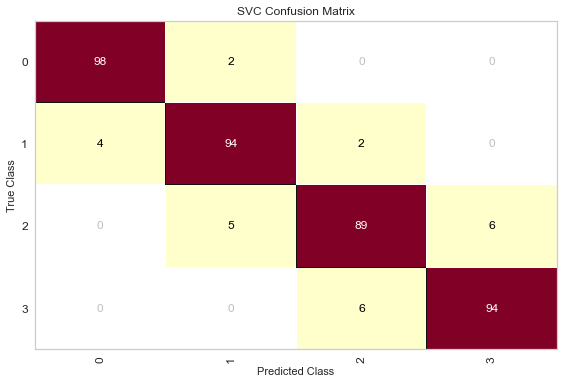

<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [19]:
cm = ConfusionMatrix(
    svm_mejorado, classes=[0,1,2,3]
)

cm.fit(X_test, y_train)
cm.score(X_test, y_test)

cm.poof()

Menor cantidad de errores 

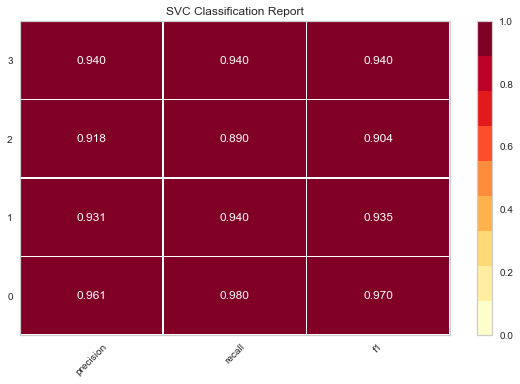

<AxesSubplot:title={'center':'SVC Classification Report'}>

In [20]:
# Rangos de precios
clases = [0,1,2,3]

# Veamos el reporte de la clasificación
visualizador = ClassificationReport(svm_mejorado, classes=clases)
visualizador.fit(X_train, y_train)        
visualizador.score(X_test, y_test)        
visualizador.show()   

Es también clara una mejoría en las demás métricas.

# Red neuronal

Realicemos ahora la clasificación mediante la red neuronal, primero volvamos a dividir los conjuntos de prueba y entrenamiento:

In [55]:
X = df.drop('price_range', axis=1).values
y = df['price_range'].values

# aplicar el método onehot
ohe = OneHotEncoder()
y= ohe.fit_transform(y.reshape(-1, 1)).toarray()

# escalando los datos
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [56]:
# creando la red
model = Sequential()

# capa de entrada
model.add(Dense(64, input_shape=(20,), activation='relu'))
model.add(Dropout(0.5))

# capas ocultas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

# capa de salida
model.add(Dense(4, activation='softmax'))

# compilando la red
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [71]:
# entrenando, a 300 épicas
history = model.fit(X_train, y_train, batch_size=16, epochs=300,
verbose=1, validation_split = 0.2, callbacks = [EarlyStopping(monitor = 'val_loss',patience = 80)])

Veamos como mejore el accuracy a lo largo de las épocas

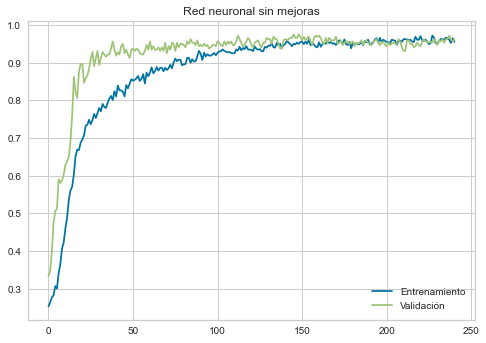

In [58]:
# graficando
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Entrenamiento', 'Validación'])
plt.title('Red neuronal sin mejoras')
plt.show()

Reestructurando las predicciones para generar el reporte:

In [59]:
# predicciones
y_predic = model.predict(X_test)

predicciones = list()
for i in range(len(y_predic)):
    predicciones.append(np.argmax(y_predic[i]))

test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

Reporte

In [60]:
print(classification_report(test, predicciones))

              precision    recall  f1-score   support

           0       0.99      0.90      0.94       100
           1       0.86      0.95      0.90       100
           2       0.94      0.93      0.93       100
           3       0.99      0.98      0.98       100

    accuracy                           0.94       400
   macro avg       0.94      0.94      0.94       400
weighted avg       0.94      0.94      0.94       400



Reestructurando las predicciones para generar la matriz de confusión:

In [61]:
y_pred = []
for proba in y_predic:
    max_valor = max(proba)
    index = list(proba).index(max_valor)
    y_pred.append(index)
    
y_t = []
for proba in y_test:
    max_valor = max(proba)
    index = list(proba).index(max_valor)
    y_t.append(index)

Matriz de confusión

In [62]:
pd.DataFrame(confusion_matrix(y_t,y_pred,labels=[0,1,2,3]),
             columns=['0_P','1_P','2_P','3_P'],
             index=['0_V','1_V','2_V','3_V'])

,0_P,1_P,2_P,3_P
0_V,90,10,0,0
1_V,1,95,4,0
2_V,0,6,93,1
3_V,0,0,2,98


## Mejorando red neuronal

Usemos ahora las variables que tienen mayor correlación:

In [63]:
X = df[['battery_power', 'px_height', 'px_width', 'ram']].values
y = df['price_range'].values

# aplicar el método onehot
ohe = OneHotEncoder()
y= ohe.fit_transform(y.reshape(-1, 1)).toarray()

# escalando los datos
sc = StandardScaler()
X = sc.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [64]:
# creando la red
model = Sequential()

# capa de entrada
model.add(Dense(64, input_shape=(4,), activation='relu'))
model.add(Dropout(0.5))

# capas ocultas
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='relu'))
model.add(Dropout(0.5))

# capa de salida
model.add(Dense(4, activation='softmax'))

# compilando la red
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [72]:
# entrenando, a 300 épicas
history = model.fit(X_train, y_train, batch_size=16, epochs=300,
verbose=1, validation_split = 0.2, callbacks = [EarlyStopping(monitor = 'val_loss',patience = 80)])

Evolución del accuracy

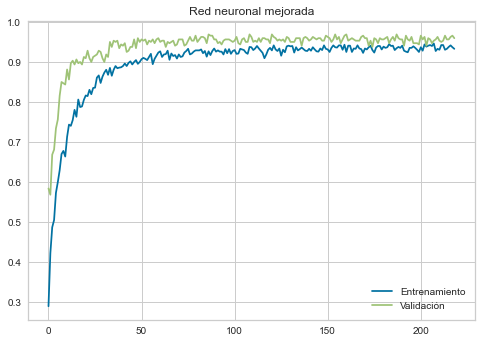

In [66]:
# graficando
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['Entrenamiento', 'Validación'])
plt.title('Red neuronal mejorada')
plt.show()

In [67]:
# predicciones
y_predic = model.predict(X_test)

predicciones = list()
for i in range(len(y_predic)):
    predicciones.append(np.argmax(y_predic[i]))

test = list()
for i in range(len(y_test)):
    test.append(np.argmax(y_test[i]))

Reporte

In [68]:
print(classification_report(test, predicciones))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       100
           1       0.87      0.99      0.93       100
           2       0.96      0.92      0.94       100
           3       0.99      0.96      0.97       100

    accuracy                           0.95       400
   macro avg       0.95      0.95      0.95       400
weighted avg       0.95      0.95      0.95       400



Se nota una mejoría en las métricas con respecto al modelo que considera todas las variables

In [69]:
y_pred = []
for proba in y_predic:
    max_valor = max(proba)
    index = list(proba).index(max_valor)
    y_pred.append(index)
    
y_t = []
for proba in y_test:
    max_valor = max(proba)
    index = list(proba).index(max_valor)
    y_t.append(index)

Matriz de confusión

In [70]:
pd.DataFrame(confusion_matrix(y_t,y_pred,labels=[0,1,2,3]),
             columns=['0_P','1_P','2_P','3_P'],
             index=['0_V','1_V','2_V','3_V'])

,0_P,1_P,2_P,3_P
0_V,92,8,0,0
1_V,1,99,0,0
2_V,0,7,92,1
3_V,0,0,4,96
